## Imports y configuraciones

In [35]:
import os
import shutil
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ref. https://keras.io/examples/vision/image_classification_from_scratch/
# Ref. https://keras.io/api/applications/xception/
# Ref. https://www.youtube.com/watch?v=dFdMyUbtKM4

## Descarga y preparación del dataset

In [36]:
# Definir rutas
data_dir = "data"
zip_path = os.path.join(data_dir, "kagglecatsanddogs_5340.zip")
extract_path = os.path.join(data_dir, "kagglecatsanddogs")
final_path = os.path.join(data_dir, "PetImages")

url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Crear la carpeta si no existe
os.makedirs(data_dir, exist_ok=True)

# Descargar el archivo si no existe
if not os.path.exists(zip_path):
    print("Descargando dataset...")
    urllib.request.urlretrieve(url, zip_path)
    print(f"Dataset descargado en {zip_path}")
else:
    print("El dataset ya está descargado.")

# Descomprimir el archivo
print("Extrayendo dataset...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)
print("Extracción completada.")

# Mover la carpeta PetImages a data/ si aún no está allí
if not os.path.exists(final_path):
    shutil.move(os.path.join(extract_path, "PetImages"), final_path)
    print("Carpeta PetImages movida correctamente.")
else:
    print("La carpeta PetImages ya existe en data/.")

# Eliminar el archivo ZIP
os.remove(zip_path)
print("Archivo ZIP eliminado.")

# Eliminar únicamente los dos archivos no deseados en data/
for file_name in ["CDLA-Permissive-2.0.pdf", "readme[1].txt"]:
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Eliminado: {file_name}")

print("Limpieza completada.")
print(f"Dataset listo en {final_path}")

Descargando dataset...
Dataset descargado en data/kagglecatsanddogs_5340.zip
Extrayendo dataset...
Extracción completada.
La carpeta PetImages ya existe en data/.
Archivo ZIP eliminado.
Eliminado: CDLA-Permissive-2.0.pdf
Eliminado: readme[1].txt
Limpieza completada.
Dataset listo en data/PetImages


## Filtrado de imágenes corruptas en el dataset

In [37]:
# Contador de imágenes corruptas
num_skipped = 0

# Rutas de las carpetas de imágenes
base_path = "data/PetImages"

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(base_path, folder_name)

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)

        try:
            with open(fpath, "rb") as fobj:
                is_jfif = b"JFIF" in fobj.peek(10)  # Revisar los primeros 10 bytes
        except Exception as e:
            print(f"⚠️ Error al leer {fpath}: {e}")
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)  # Eliminar imagen corrupta
            print(f"🗑️ Imagen corrupta eliminada: {fpath}")

print(f"✅ Eliminadas {num_skipped} imágenes corruptas.")

🗑️ Imagen corrupta eliminada: data/PetImages/Cat/2114.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/837.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/9069.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/8388.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/88.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/6602.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/12046.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/1151.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/12126.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/1757.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/9492.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/1970.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/3197.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/6951.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/3183.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/7642.jpg
🗑️ Imagen corrupta eliminada: data/PetImages/Cat/7865.jpg
🗑️ Imagen corru

## Creación de los datasets de entrenamiento y validación y visualización

In [38]:
# Parámetros del dataset
image_size = (180, 180)
batch_size = 128

# Generar los datasets de entrenamiento y validación
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data/PetImages",  # Ruta corregida
    validation_split=0.2,  # 20% de los datos para validación
    subset="both",  # Separa los conjuntos de entrenamiento y validación
    seed=1337,  # Para reproducibilidad
    image_size=image_size,  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,  # Tamaño de lote
)

# Mostrar información sobre los datasets creados
print(f"✅ Dataset de entrenamiento: {len(train_ds)} batches")
print(f"✅ Dataset de validación: {len(val_ds)} batches")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
✅ Dataset de entrenamiento: 147 batches
✅ Dataset de validación: 37 batches


2025-03-17 11:11:27.496836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


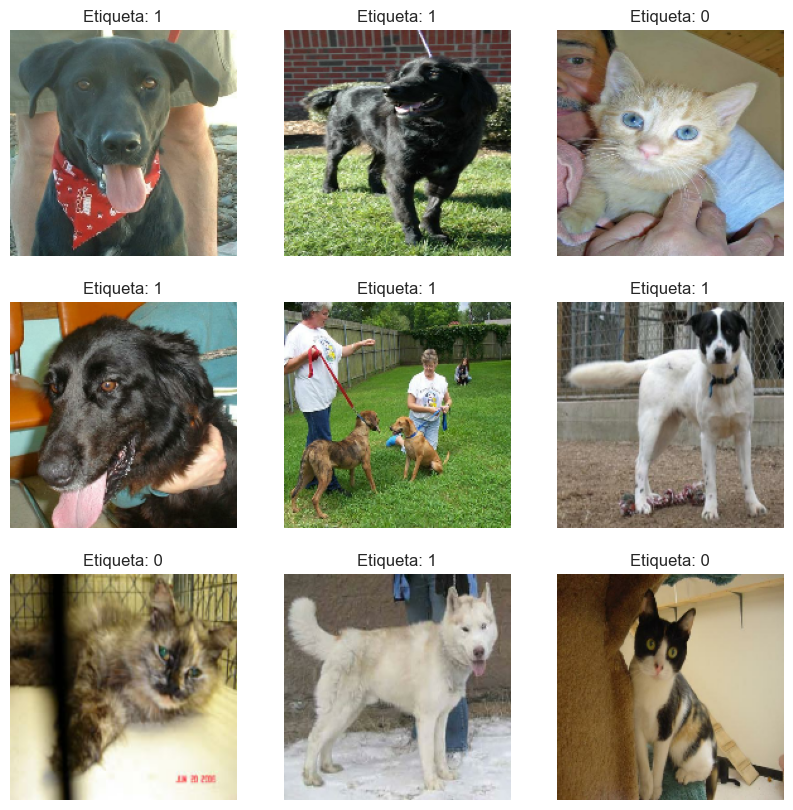

In [39]:
# Crear una figura de 10x10
plt.figure(figsize=(10, 10))

# Tomar un batch del dataset de entrenamiento
for images, labels in train_ds.take(1):
    for i in range(9):  # Mostrar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convertir a uint8 para visualizar
        plt.title(f"Etiqueta: {int(labels[i])}")  # Convertir la etiqueta a int
        plt.axis("off")

plt.show()

## Aplicación y visualización de Data Augmentation

In [40]:
# Lista de capas de Data Augmentation
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),  # Volteo horizontal aleatorio
    layers.RandomRotation(0.1),  # Rotación aleatoria de hasta 10%
]


# Función para aplicar Data Augmentation
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)  # Aplicar cada transformación secuencialmente
    return images

2025-03-17 11:11:28.252645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


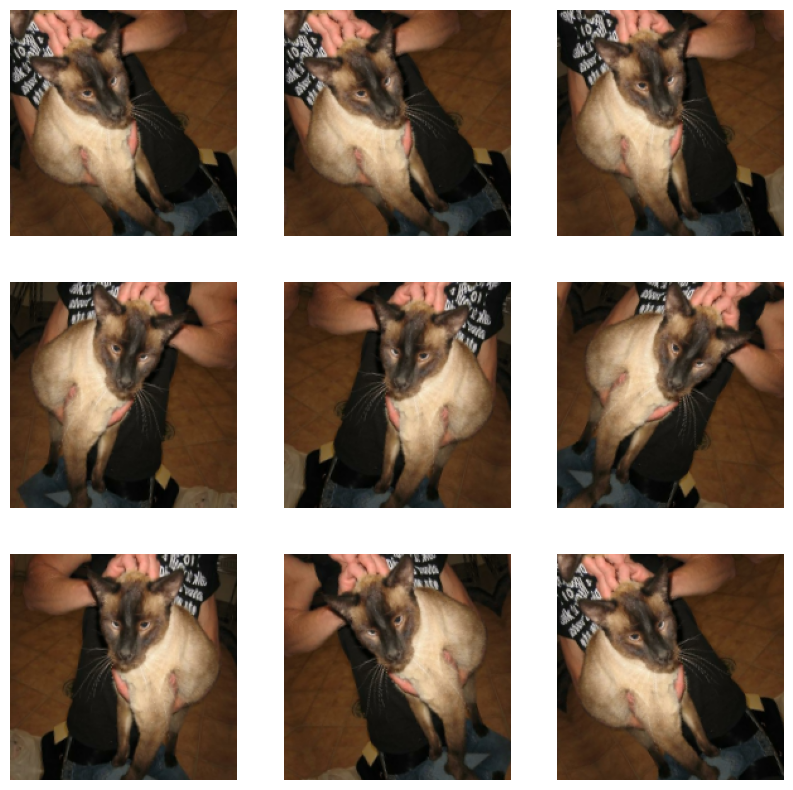

In [41]:
plt.figure(figsize=(10, 10))

# Obtener un batch de imágenes del dataset
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)[0]  # Aplicar Data Augmentation a la primera imagen del batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_image).astype("uint8"))  # Convertir a uint8 para visualizar
        plt.axis("off")

plt.show()

## Normalización y optimización del dataset

In [42]:
# Normalización de los valores de píxeles al rango [0, 1]
rescale = tf.keras.layers.Rescaling(1. / 255)

# Aplicar data augmentation y normalización al conjunto de entrenamiento
train_ds = train_ds.map(
    lambda img, label: (rescale(data_augmentation(img)), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Aplicar solo normalización al conjunto de validación
val_ds = val_ds.map(
    lambda img, label: (rescale(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetch para mejorar la eficiencia (carga datos en memoria antes de que se necesiten)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Construcción, compilación y entrenamiento del modelo

In [43]:
# Definir carpeta para guardar modelos
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)  # Crear carpeta si no existe

In [44]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Normalización
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Entrada convolucional
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Bloques de convolución residual tipo Xception
    previous_block_activation = x  # Residual connection

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Conexión residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Última capa convolucional
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Pooling Global
    x = layers.GlobalAveragePooling2D()(x)

    # Regularización con Dropout
    x = layers.Dropout(0.25)(x)

    # Capa de salida
    outputs = layers.Dense(1 if num_classes == 2 else num_classes, activation=None)(x)

    return keras.Model(inputs, outputs)

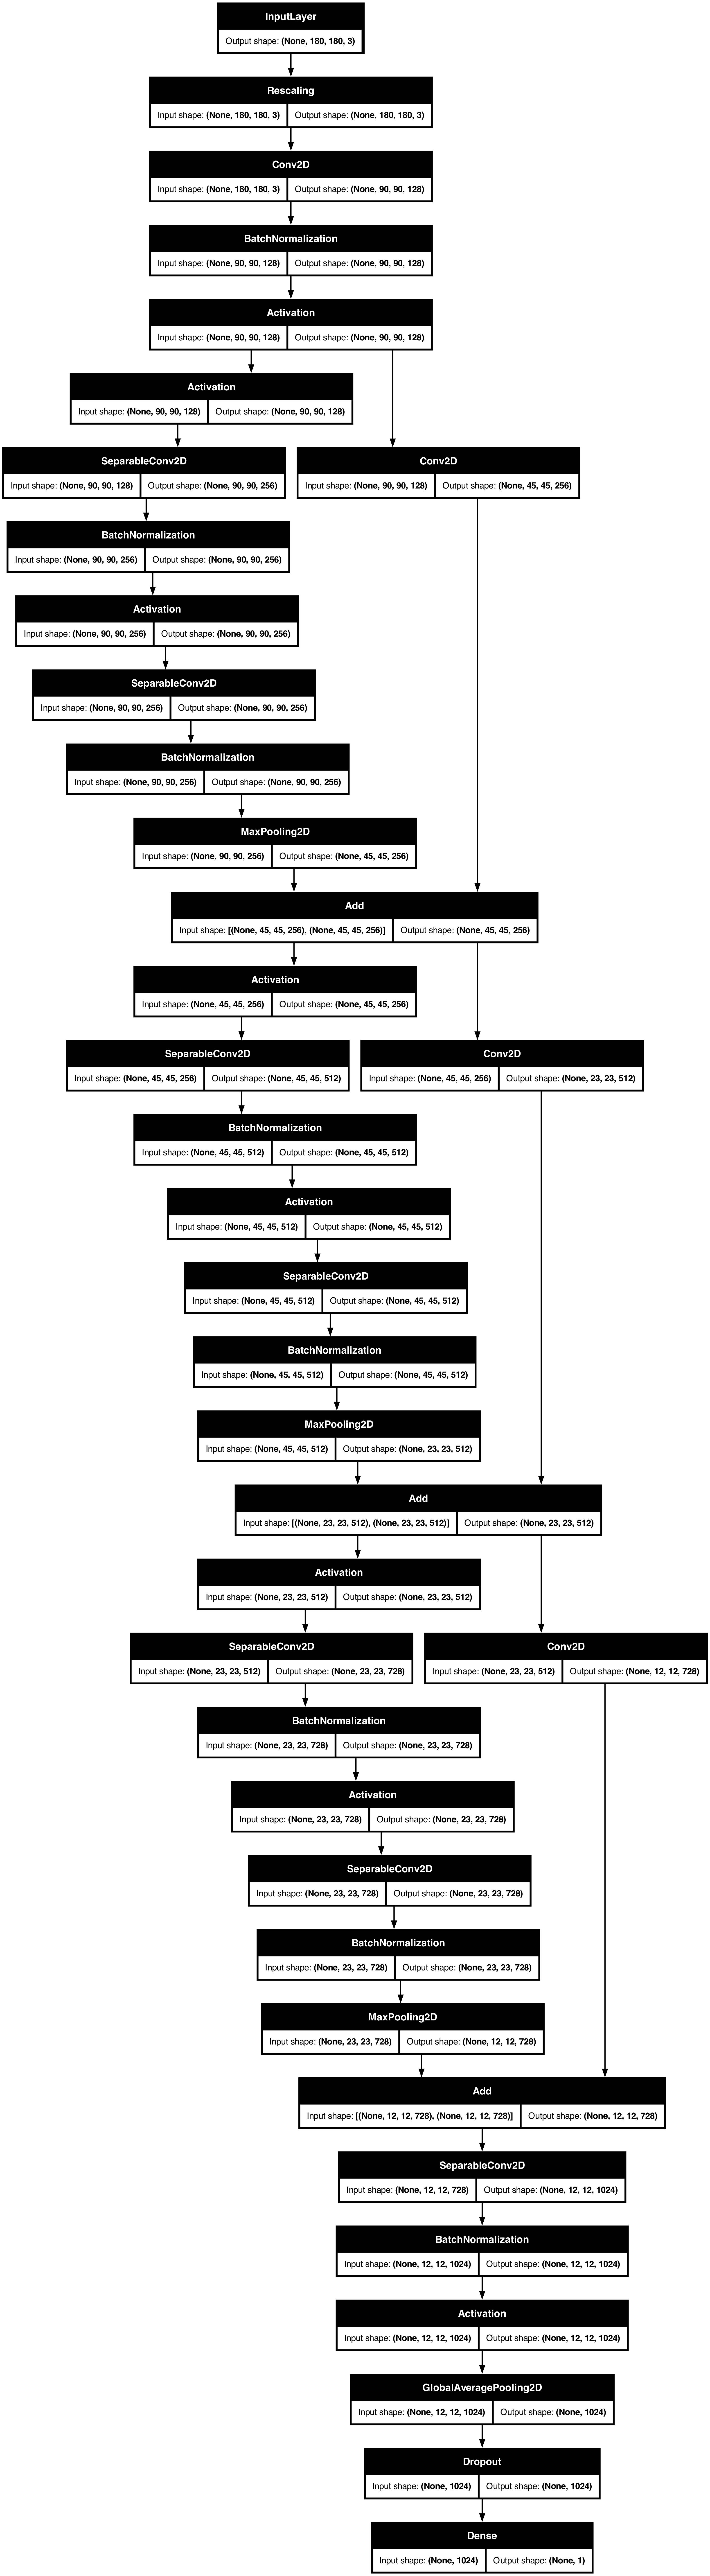

In [45]:
# Crear y visualizar el modelo
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, to_file=os.path.join(model_dir, "cats_vs_dogs_model.png"), show_shapes=True)

In [46]:
epochs = 10

# Definir el prefijo para los checkpoints
checkpoint_prefix = os.path.join(model_dir, "cats_vs_dogs_epoch_{epoch}.keras")

# Callbacks para guardar los modelos
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_prefix),
]

# Compilación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Entrenamiento del modelo
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=2,
)

Epoch 1/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 243s - 2s/step - acc: 0.6487 - loss: 0.6025 - val_acc: 0.4957 - val_loss: 0.6961
Epoch 2/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 237s - 2s/step - acc: 0.7883 - loss: 0.4327 - val_acc: 0.4957 - val_loss: 0.7117
Epoch 3/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 238s - 2s/step - acc: 0.8451 - loss: 0.3391 - val_acc: 0.4957 - val_loss: 0.6963
Epoch 4/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 236s - 2s/step - acc: 0.8794 - loss: 0.2708 - val_acc: 0.4957 - val_loss: 0.7041
Epoch 5/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 236s - 2s/step - acc: 0.8998 - loss: 0.2312 - val_acc: 0.4957 - val_loss: 2.7464
Epoch 6/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 235s - 2s/step - acc: 0.9089 - loss: 0.2082 - val_acc: 0.4957 - val_loss: 1.4764
Epoch 7/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 237s - 2s/step - acc: 0.9216 - loss: 0.1870 - val_acc: 0.4957 - val_loss: 11.4730
Epoch 8/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 238s - 2s/step - acc: 0.9294 - loss: 0.1642 - val_acc: 0.4957 - val_loss: 7.0037
Epoch 9/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 243s - 2s/step - acc: 0.9375 - loss: 0.1499 - val_acc: 0.4957 - val_loss: 4.2370
Epoch 10/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 - 236s - 2s/step - acc: 0.9388 - loss: 0.1427 - val_acc: 0.4957 - val_loss: 4.7572


## Predicción en una imagen individual

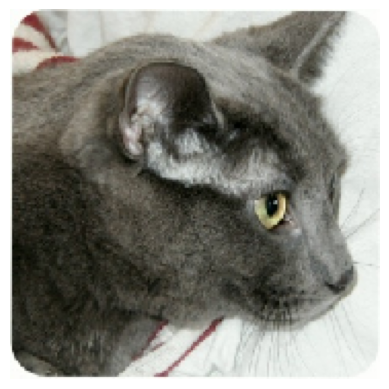

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image is 100.00% cat and 0.00% dog.


In [48]:
# Definir ruta de la imagen (ajustar según el caso)
img_path = "data/PetImages/Cat/6779.jpg"


# Función para cargar la imagen, preprocesarla y predecir
def predict_image(img_path, model):
    # Cargar la imagen y mostrarla
    img = keras.utils.load_img(img_path, target_size=image_size)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Convertir la imagen en un array y expandir dimensiones para batch
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Agregar dimensión de batch

    # Verificar que el modelo está cargado antes de predecir
    if model is None:
        raise ValueError("⚠️ El modelo no está cargado. Asegúrate de entrenarlo o cargarlo antes de predecir.")

    # Hacer la predicción
    predictions = model.predict(img_array)

    # Aplicar la función sigmoide para obtener probabilidad entre 0 y 1
    score = float(tf.sigmoid(predictions[0][0]))

    # Mostrar el resultado
    print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


# Llamar a la función con la imagen seleccionada
predict_image(img_path, model)